In [36]:
# importing libraries

import pandas as pd
from collections import Counter
import torch
import seaborn as sns
from torch.utils.data import DataLoader,Dataset, TensorDataset
import torch.nn as nn
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import json
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F

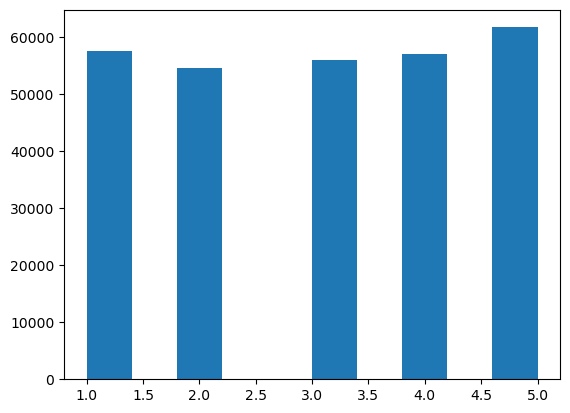

In [5]:
# initial data loading and preparation

RawData = []
NumItems = 2000000                            # for initial testing
counter = 0

with open('Electronics_5.json') as file:
    for line in file:
        # RawData.append(json.loads(line))
        if counter < NumItems:              # for initial testing
            RawData.append(json.loads(line))
        else:
            pass
        counter = counter + 1

RatingCount = {1:0, 2:0, 3:0, 4:0, 5:0}
AdjustedRawData = []
NumForRating = 65536

for line in RawData:
    try:
        if RatingCount[line["overall"]] < NumForRating:
            AdjustedRawData.append(line)
            RatingCount[line["overall"]] = RatingCount[line["overall"]] + 1
        else:
            pass
    except:
        pass



revLength = 1024 # choose the cutoff for number of characters in a review - longer ones will not be considered
Reviews = []
Ratings = []
NonOneHotRatings = []
MaxLength = 0

for count in range(len(AdjustedRawData)):
    try:
        review = (AdjustedRawData[count]['summary'] + ' ' + AdjustedRawData[count]['reviewText']).lower()
        if len(review) < revLength:
            Reviews.append(review)
            Ratings.append(AdjustedRawData[count]['overall'])
            if len(review) > MaxLength:
                MaxLength = len(review)
        else:
            pass
    except:
        pass

Reviews = np.array(Reviews)
Ratings = np.array(Ratings)
Ratings = np.int64(Ratings)

plt.hist(Ratings)
plt.show()

In [66]:
# embedding ANN

emb_ANN = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

In [68]:
# embedding reviews

# ReviewsIndexed = emb_ANN.encode(Reviews)
# # with open("data/Amazon_reviews.pkl", "wb") as output_file:
# #     pickle.dump(ReviewsIndexed, output_file)

with open("data/Amazon_reviews.pkl", "rb") as input_file:
    ReviewsIndexed = pickle.load(input_file)

In [89]:
# hyperparameters

batchsize = 64
numepochs = 10
hiddenlaywidth = 1024
learningrate = .01
dropoutrate = .5

In [6]:
# train test split and dataloaders

X_train, X_test, y_train, y_test = train_test_split(ReviewsIndexed, Ratings, test_size=0.8, random_state=666)

class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

TrainDataset = ClassificationDataset(X= X_train, y = y_train)
TestDataset = ClassificationDataset(X_test, y_test)

TrainLoader = DataLoader(dataset=TrainDataset, batch_size=batchsize, shuffle=True, drop_last=True)
TestLoader = DataLoader(TestDataset, batch_size=len(list(TestDataset)))

In [90]:
# ANN architecture

class ClassificationANN(nn.Module):
    def __init__(self, numfeatures, numclasses, hiddenlaywidth = hiddenlaywidth, dropoutrate = dropoutrate):
        super().__init__()
        self.input = nn.Linear(numfeatures, hiddenlaywidth)
        self.hidden = nn.Linear(hiddenlaywidth,hiddenlaywidth)
        self.output = nn.Linear(hiddenlaywidth, numclasses)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.dr = dropoutrate
        
    def forward(self, x):

        x = self.input(x)
        x = self.relu(x)
        # x = F.dropout(x, p=self.dr, training=self.training)

        x = self.hidden(x)
        x = self.relu(x)
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.hidden(x)
        x = self.relu(x)
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)
        x = self.log_softmax(x)

        return x

In [91]:
# # ANN instance, loss function and optimizer
    
ANN = ClassificationANN(numfeatures = X_train.shape[1], numclasses = 6)
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ANN.parameters(),lr=learningrate)

Epoch 0, Loss: 1.1083418342417903, Test Accuracy: 57.63612389564514
Epoch 1, Loss: 1.0428858567694468, Test Accuracy: 55.958038568496704
Epoch 2, Loss: 1.0317675791281675, Test Accuracy: 59.22272801399231
Epoch 3, Loss: 1.006194988930864, Test Accuracy: 58.299171924591064
Epoch 4, Loss: 0.9712418207366552, Test Accuracy: 59.540748596191406
Epoch 5, Loss: 0.9829893367631095, Test Accuracy: 58.170223236083984
Epoch 6, Loss: 0.9681937787016588, Test Accuracy: 57.91842341423035
Epoch 7, Loss: 0.974069998732635, Test Accuracy: 59.0532660484314
Epoch 8, Loss: 0.9599266299711806, Test Accuracy: 60.602402687072754
Epoch 9, Loss: 0.9623150347199824, Test Accuracy: 59.736788272857666
The accuracy of the model is 59.699999999999996%.


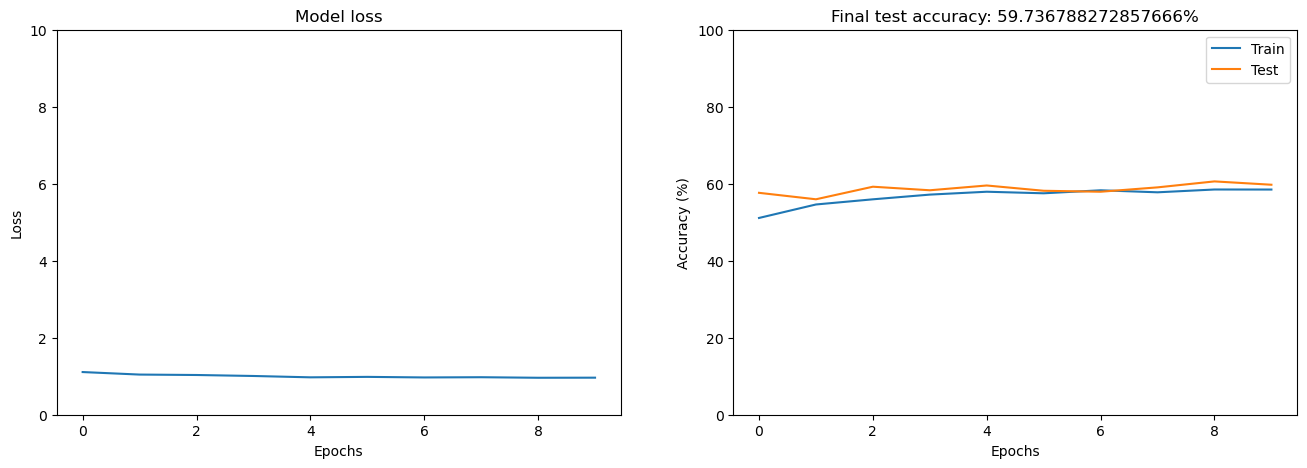

In [92]:
# ANN Training

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(numepochs):

    ANN.train()

    curr_loss = []
    curr_acc = []
    
    for X_batch, y_batch in TrainLoader:

        y_hat = ANN(X_batch)
        loss = lossfunc(y_hat, y_batch.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss.append(loss.item())

        matches = torch.argmax(y_hat,axis=1) == y_batch
        matches_num = matches.float()
        percent_accuracy = 100*torch.mean(matches_num)
        curr_acc.append(percent_accuracy)

    curr_loss = np.mean(curr_loss)

    train_losses.append(curr_loss)
    train_accuracies.append(np.mean(curr_acc))

    # print(f"Epoch {epoch}, Loss: {curr_loss}")

    # ANN testing

    ANN.eval()

    with torch.no_grad():
        X_batch, y_batch = next(iter(TestLoader))
        y_test_pred_log = ANN(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)
        curr_test_acc = 100*torch.mean((y_test_pred==y_batch).float()).item()
        test_accuracies.append(curr_test_acc)

        print(f"Epoch {epoch}, Loss: {curr_loss}, Test Accuracy: {curr_test_acc}")

    y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
print(f"The accuracy of the model is {np.round(acc, 3)*100}%.")

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,10])
ax[0].set_title('Model loss')

ax[1].plot(train_accuracies,label='Train')
ax[1].plot(test_accuracies,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([0,100])
ax[1].set_title('Final test accuracy: {}%'.format(test_accuracies[-1]))
ax[1].legend()

plt.show()

In [93]:
# experimenting with continued training and various learning rates

learningrate = .001
optimizer = torch.optim.AdamW(ANN.parameters(),lr=learningrate)

Epoch 0, Loss: 0.9075577831161874, Test Accuracy: 61.17222309112549
Epoch 1, Loss: 0.8847381485226963, Test Accuracy: 61.58956289291382
Epoch 2, Loss: 0.8663158001644271, Test Accuracy: 61.807823181152344
Epoch 3, Loss: 0.8618409847840667, Test Accuracy: 61.86837553977966
Epoch 4, Loss: 0.8539595339846399, Test Accuracy: 61.809128522872925
Epoch 5, Loss: 0.8472397490404546, Test Accuracy: 61.78865432739258
Epoch 6, Loss: 0.8438279476415899, Test Accuracy: 61.813485622406006
Epoch 7, Loss: 0.8387240776792169, Test Accuracy: 61.77253723144531
Epoch 8, Loss: 0.8360127600442085, Test Accuracy: 61.909323930740356
Epoch 9, Loss: 0.8298511777871421, Test Accuracy: 62.1097207069397
The accuracy of the model is 62.1%.


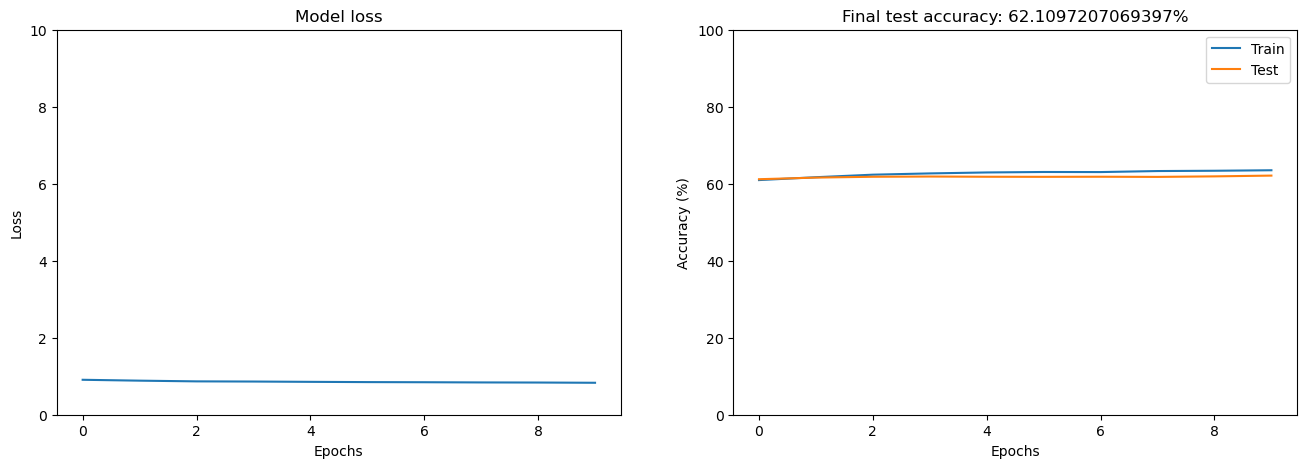

In [94]:
# ANN Training - although the test accuracy is higher, the model seemed to fare a bit better in interative testing after just one round of training

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(numepochs):

    ANN.train()

    curr_loss = []
    curr_acc = []
    
    for X_batch, y_batch in TrainLoader:

        y_hat = ANN(X_batch)
        loss = lossfunc(y_hat, y_batch.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss.append(loss.item())

        matches = torch.argmax(y_hat,axis=1) == y_batch
        matches_num = matches.float()
        percent_accuracy = 100*torch.mean(matches_num)
        curr_acc.append(percent_accuracy)

    curr_loss = np.mean(curr_loss)

    train_losses.append(curr_loss)
    train_accuracies.append(np.mean(curr_acc))

    # print(f"Epoch {epoch}, Loss: {curr_loss}")

    # ANN testing

    ANN.eval()

    with torch.no_grad():
        X_batch, y_batch = next(iter(TestLoader))
        y_test_pred_log = ANN(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)
        curr_test_acc = 100*torch.mean((y_test_pred==y_batch).float()).item()
        test_accuracies.append(curr_test_acc)

        print(f"Epoch {epoch}, Loss: {curr_loss}, Test Accuracy: {curr_test_acc}")

    y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
print(f"The accuracy of the model is {np.round(acc, 3)*100}%.")

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,10])
ax[0].set_title('Model loss')

ax[1].plot(train_accuracies,label='Train')
ax[1].plot(test_accuracies,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([0,100])
ax[1].set_title('Final test accuracy: {}%'.format(test_accuracies[-1]))
ax[1].legend()

plt.show()

In [95]:
# experimenting with continued training and various learning rates

learningrate = .0001
optimizer = torch.optim.AdamW(ANN.parameters(),lr=learningrate)

Epoch 0, Loss: 0.8205726167320141, Test Accuracy: 62.033045291900635
Epoch 1, Loss: 0.8209899294057063, Test Accuracy: 62.05657124519348
Epoch 2, Loss: 0.8178714898281864, Test Accuracy: 61.98817491531372
Epoch 3, Loss: 0.8173223875596055, Test Accuracy: 62.004733085632324
Epoch 4, Loss: 0.8167527521561299, Test Accuracy: 61.9851291179657
Epoch 5, Loss: 0.8160458466570292, Test Accuracy: 62.07225322723389
Epoch 6, Loss: 0.8149782135816557, Test Accuracy: 62.032175064086914
Epoch 7, Loss: 0.8154272706513959, Test Accuracy: 62.0500385761261
Epoch 8, Loss: 0.815318307905857, Test Accuracy: 62.032610177993774
Epoch 9, Loss: 0.8127140099448817, Test Accuracy: 62.033045291900635
The accuracy of the model is 62.0%.


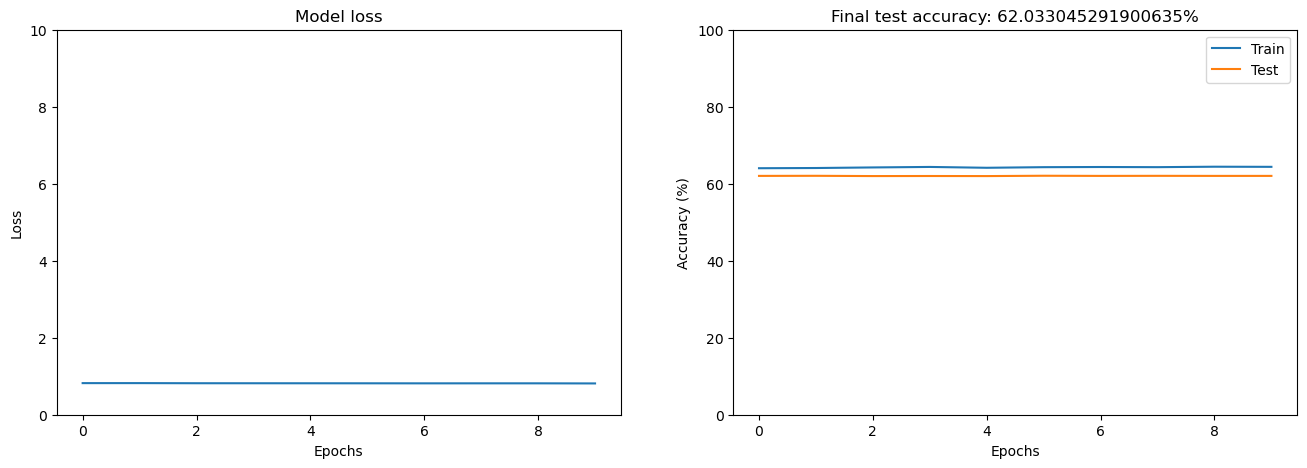

In [96]:
# ANN Training - although the test accuracy is higher, the model seemed to fare a bit better in interative testing after just one round of training

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(numepochs):

    ANN.train()

    curr_loss = []
    curr_acc = []
    
    for X_batch, y_batch in TrainLoader:

        y_hat = ANN(X_batch)
        loss = lossfunc(y_hat, y_batch.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss.append(loss.item())

        matches = torch.argmax(y_hat,axis=1) == y_batch
        matches_num = matches.float()
        percent_accuracy = 100*torch.mean(matches_num)
        curr_acc.append(percent_accuracy)

    curr_loss = np.mean(curr_loss)

    train_losses.append(curr_loss)
    train_accuracies.append(np.mean(curr_acc))

    # print(f"Epoch {epoch}, Loss: {curr_loss}")

    # ANN testing

    ANN.eval()

    with torch.no_grad():
        X_batch, y_batch = next(iter(TestLoader))
        y_test_pred_log = ANN(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)
        curr_test_acc = 100*torch.mean((y_test_pred==y_batch).float()).item()
        test_accuracies.append(curr_test_acc)

        print(f"Epoch {epoch}, Loss: {curr_loss}, Test Accuracy: {curr_test_acc}")

    y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
print(f"The accuracy of the model is {np.round(acc, 3)*100}%.")

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,10])
ax[0].set_title('Model loss')

ax[1].plot(train_accuracies,label='Train')
ax[1].plot(test_accuracies,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([0,100])
ax[1].set_title('Final test accuracy: {}%'.format(test_accuracies[-1]))
ax[1].legend()

plt.show()

In [97]:
# testing using some fake generated reviews and scores

RatingsIntTesting = np.array([5, 1, 5, 1, 5, 2, 5, 2, 5, 1, 5, 2, 5, 1, 5, 1, 5, 2, 5, 1, 5, 1, 5, 1, 5, 2, 5, 1, 5, 2, 5, 1, 5, 1, 5, 2, 5, 1, 5, 2, 5, 1, 5, 2, 5, 1, 5, 1, 5, 2, 5, 1, 5, 1, 5, 1, 5, 2, 5, 1, 5, 2, 5, 1])
ReviewsIntTesting = ["This product changed my life! I can't believe I lived without it.",
"Total waste of money. Didn't work as advertised.",
"Excellent quality and fast shipping. Highly recommend.",
"Terrible experience. Broke within a week. Avoid at all costs.",
"Amazing product! Does exactly what it promises.",
"Disappointed. Cheap materials, fell apart instantly.",
"Best purchase ever! So happy with the results.",
"Overpriced and underwhelming. Not worth the hype.",
"Life-changing! Can't believe I didn't buy it sooner.",
"Faulty from the start. Customer service is a nightmare.",
"Incredible value for the money. I'm impressed.",
"Didn't meet my expectations. Mediocre at best.",
"Top-notch quality and design. Worth every penny.",
"Complete scam! Don't waste your hard-earned money.",
"Game-changer! I'm so pleased with this purchase.",
"Defective product. Avoid the frustration, buy elsewhere.",
"Exactly what I needed. Great product, great price.",
"Poorly made. Broke after minimal use. Disappointed.",
"Five stars! Excellent quality and fast delivery.",
"Regret buying this. Doesn't work as advertised.",
"Highly recommend! Great customer service too.",
"Cheap and useless. Save your money, look elsewhere.",
"Outstanding product! Can't imagine life without it now.",
"Total rip-off. Fell apart within days. Disgusted.",
"Absolutely love it! Worth every penny spent.",
"False advertising! Product didn't do what it claimed.",
"Great value for the price. Surpassed my expectations.",
"Junk! Broke after one use. Waste of money.",
"Fantastic product! Exceeded my expectations.",
"Disappointed. Not durable as promised.",
"Highly satisfied! Quality product and speedy delivery.",
"Stay away! Cheaply made, fell apart instantly.",
"This product is a game-changer! It exceeded my expectations.",
"Absolutely terrible. Broke within a day. Waste of money.",
"Fast shipping and excellent quality. Highly recommend.",
"Disappointing. Poor quality, fell apart quickly.",
"Fantastic product! Works like a charm.",
"Not worth it. Cheaply made, didn't last.",
"Highly satisfied with my purchase.",
"Overpriced for the quality. Not impressed.",
"Life-changing product! Can't imagine living without it.",
"Defective from the start. Disappointed.",
"Great value for money. Impressed with the results.",
"Didn't meet expectations. Average at best.",
"Top-notch quality! Worth every penny.",
"Total scam! Avoid at all costs.",
"Love it! Exceeded my expectations.",
"Faulty product. Regret purchasing.",
"Exactly what I needed. Excellent product.",
"Poorly made. Broke after minimal use. Disappointing.",
"Five stars! Great quality and speedy delivery.",
"Regret buying. Doesn't live up to claims.",
"Highly recommend! Great customer service.",
"Cheap and useless. Save your money.",
"Outstanding product! Can't live without it now.",
"Total rip-off. Fell apart within days. Disgusting.",
"Absolutely love it! Worth every penny.",
"False advertising. Product didn't deliver.",
"Great value for the price. Surpassed expectations.",
"Junk! Broke after one use. Waste of money.",
"Fantastic product! Exceeded my expectations.",
"Disappointed. Not durable as promised.",
"Highly satisfied! Quality product and speedy delivery.",
"Stay away! Cheaply made, fell apart instantly."]

RatingsIntTesting = torch.Tensor(RatingsIntTesting)
ReviewsIntTestingEncoded = emb_ANN.encode(ReviewsIntTesting)
IntTesting = ClassificationDataset(X = ReviewsIntTestingEncoded, y = RatingsIntTesting)
IntTestingLoader = DataLoader(dataset=IntTesting, batch_size=1)

PredRatngsIntTesting = []
for X_batch, y_batch in IntTestingLoader:
    y_test_pred_log = ANN(X_batch)
    y_test_pred = torch.argmax(y_test_pred_log, dim = 1)
    PredRatngsIntTesting.append(int(y_test_pred))

# printing wrong guesses to look for concerningly inaccurate classification

for number in range(len(PredRatngsIntTesting)):
    if PredRatngsIntTesting[number] != int(RatingsIntTesting[number]):
        print(PredRatngsIntTesting[number], "stars predicted,", int(RatingsIntTesting[number]), "stars actual:", ReviewsIntTesting[number])

1 stars predicted, 2 stars actual: Disappointed. Cheap materials, fell apart instantly.
1 stars predicted, 2 stars actual: Overpriced and underwhelming. Not worth the hype.
1 stars predicted, 2 stars actual: Poorly made. Broke after minimal use. Disappointed.
1 stars predicted, 2 stars actual: False advertising! Product didn't do what it claimed.
1 stars predicted, 2 stars actual: Disappointed. Not durable as promised.
1 stars predicted, 2 stars actual: Overpriced for the quality. Not impressed.
1 stars predicted, 2 stars actual: Poorly made. Broke after minimal use. Disappointing.
1 stars predicted, 2 stars actual: False advertising. Product didn't deliver.
1 stars predicted, 2 stars actual: Disappointed. Not durable as promised.


In [98]:
# interactive testing

RatingsIntTesting = np.array([5, 1, 5, 1, 5, 2, 5, 2, 5, 1, 5, 2, 5, 1, 5, 1, 5, 2, 5, 1, 5, 1, 5, 1, 5, 2, 5, 1, 5, 2, 5, 1, 5, 1, 5, 2, 5, 1, 5, 2, 5, 1, 5, 2, 5, 1, 5, 1, 5, 2, 5, 1, 5, 1, 5, 1, 5, 2, 5, 1, 5, 2, 5, 1])
ReviewsIntTesting = ["This product changed my life! I can't believe I lived without it.",
"Total waste of money. Didn't work as advertised.",
"Excellent quality and fast shipping. Highly recommend.",
"Terrible experience. Broke within a week. Avoid at all costs.",
"Amazing product! Does exactly what it promises.",
"Disappointed. Cheap materials, fell apart instantly.",
"Best purchase ever! So happy with the results.",
"Overpriced and underwhelming. Not worth the hype.",
"Life-changing! Can't believe I didn't buy it sooner.",
"Faulty from the start. Customer service is a nightmare.",
"Incredible value for the money. I'm impressed.",
"Didn't meet my expectations. Mediocre at best.",
"Top-notch quality and design. Worth every penny.",
"Complete scam! Don't waste your hard-earned money.",
"Game-changer! I'm so pleased with this purchase.",
"Defective product. Avoid the frustration, buy elsewhere.",
"Exactly what I needed. Great product, great price.",
"Poorly made. Broke after minimal use. Disappointed.",
"Five stars! Excellent quality and fast delivery.",
"Regret buying this. Doesn't work as advertised.",
"Highly recommend! Great customer service too.",
"Cheap and useless. Save your money, look elsewhere.",
"Outstanding product! Can't imagine life without it now.",
"Total rip-off. Fell apart within days. Disgusted.",
"Absolutely love it! Worth every penny spent.",
"False advertising! Product didn't do what it claimed.",
"Great value for the price. Surpassed my expectations.",
"Junk! Broke after one use. Waste of money.",
"Fantastic product! Exceeded my expectations.",
"Disappointed. Not durable as promised.",
"Highly satisfied! Quality product and speedy delivery.",
"Stay away! Cheaply made, fell apart instantly.",
"This product is a game-changer! It exceeded my expectations.",
"Absolutely terrible. Broke within a day. Waste of money.",
"Fast shipping and excellent quality. Highly recommend.",
"Disappointing. Poor quality, fell apart quickly.",
"Fantastic product! Works like a charm.",
"Not worth it. Cheaply made, didn't last.",
"Highly satisfied with my purchase.",
"Overpriced for the quality. Not impressed.",
"Life-changing product! Can't imagine living without it.",
"Defective from the start. Disappointed.",
"Great value for money. Impressed with the results.",
"Didn't meet expectations. Average at best.",
"Top-notch quality! Worth every penny.",
"Total scam! Avoid at all costs.",
"Love it! Exceeded my expectations.",
"Faulty product. Regret purchasing.",
"Exactly what I needed. Excellent product.",
"Poorly made. Broke after minimal use. Disappointing.",
"Five stars! Great quality and speedy delivery.",
"Regret buying. Doesn't live up to claims.",
"Highly recommend! Great customer service.",
"Cheap and useless. Save your money.",
"Outstanding product! Can't live without it now.",
"Total rip-off. Fell apart within days. Disgusting.",
"Absolutely love it! Worth every penny.",
"False advertising. Product didn't deliver.",
"Great value for the price. Surpassed expectations.",
"Junk! Broke after one use. Waste of money.",
"Fantastic product! Exceeded my expectations.",
"Disappointed. Not durable as promised.",
"Highly satisfied! Quality product and speedy delivery.",
"Stay away! Cheaply made, fell apart instantly."]

ReviewsIntTesting[0] = (input("Please wtrite your test review here:"))

RatingsIntTesting = torch.Tensor(RatingsIntTesting)
ReviewsIntTestingEncoded = emb_ANN.encode(ReviewsIntTesting)
IntTesting = ClassificationDataset(X = ReviewsIntTestingEncoded, y = RatingsIntTesting)
IntTestingLoader = DataLoader(dataset=IntTesting, batch_size=1)

PredRatngsIntTesting = []
for X_batch, y_batch in IntTestingLoader:
    y_test_pred_log = ANN(X_batch)
    y_test_pred = torch.argmax(y_test_pred_log, dim = 1)
    PredRatngsIntTesting.append(int(y_test_pred))

print(f"Review: {ReviewsIntTesting[0]}")
print(f"The predicted rating for your review is {PredRatngsIntTesting[0]} stars.")

Review:  The ASUS Zenfone 10 is a well-rounded smartphone that excels in design, performance, and camera capabilities. With a vibrant display, robust processing power, and thoughtful software enhancements, it offers a compelling package for users seeking a reliable and feature-packed device. Whether you're a photography enthusiast, a mobile gamer, or someone who values a long-lasting battery, the ASUS Zenfone 10 is a commendable choice in the competitive smartphone market.
The predicted rating for your review is 4 stars.


In [48]:
# saving/loading model

torch.save(ANN.state_dict(), 'trained_text_classification_ANN_dropout_lr01.pt')

# # model after 1 round of testing - test accuracy ~57%, but seemingly better in interactive testing
# ANN = ClassificationANN(numfeatures = X_train.shape[1], numclasses = 6)
# ANN.load_state_dict(torch.load('trained_text_classification_ANN.pt'))

# # model after a few rounds of training - test accuract ~61.6%, but seemingly worse in interactive testing
# ANN = ClassificationANN(numfeatures = X_train.shape[1], numclasses = 6)
# ANN.load_state_dict(torch.load('trained_text_classification_ANN_lottayears.pt'))